In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/health-insurance-dataset/Hospitalisation details.csv
/kaggle/input/health-insurance-dataset/Medical Examinations.csv
/kaggle/input/health-insurance-dataset/Names.xlsx


In [2]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import SGDRegressor, Ridge
from sklearn.model_selection import KFold, StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error as mse, r2_score 
from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import plotly.express as px
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import f_oneway
from scipy.stats import chi2_contingency
from scipy.stats import kruskal
import xgboost as xgb
from xgboost import XGBRegressor

In [3]:
import warnings 
warnings.filterwarnings('ignore')

In [4]:
#Supervised regression 
hosp = pd.read_csv('/kaggle/input/health-insurance-dataset/Hospitalisation details.csv')

In [5]:
med = pd.read_csv('/kaggle/input/health-insurance-dataset/Medical Examinations.csv')
names = pd.read_excel('/kaggle/input/health-insurance-dataset/Names.xlsx')

In [6]:
hosp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2343 entries, 0 to 2342
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Customer ID    2343 non-null   object 
 1   year           2343 non-null   object 
 2   month          2343 non-null   object 
 3   date           2343 non-null   int64  
 4   children       2343 non-null   int64  
 5   charges        2343 non-null   float64
 6   Hospital tier  2343 non-null   object 
 7   City tier      2343 non-null   object 
 8   State ID       2343 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 164.9+ KB


In [7]:
med.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2335 entries, 0 to 2334
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Customer ID             2335 non-null   object 
 1   BMI                     2335 non-null   float64
 2   HBA1C                   2335 non-null   float64
 3   Heart Issues            2335 non-null   object 
 4   Any Transplants         2335 non-null   object 
 5   Cancer history          2335 non-null   object 
 6   NumberOfMajorSurgeries  2335 non-null   object 
 7   smoker                  2335 non-null   object 
dtypes: float64(2), object(6)
memory usage: 146.1+ KB


In [8]:
names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2335 entries, 0 to 2334
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Customer ID  2335 non-null   object
 1   name         2335 non-null   object
dtypes: object(2)
memory usage: 36.6+ KB


In [9]:
# Collate the files so that all the information is in one place using the common column - customer id
master_data = pd.merge(hosp, med, how = "inner", on = 'Customer ID')

In [10]:
master_data = master_data.merge(names, on = "Customer ID")

In [11]:
master_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2335 entries, 0 to 2334
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Customer ID             2335 non-null   object 
 1   year                    2335 non-null   object 
 2   month                   2335 non-null   object 
 3   date                    2335 non-null   int64  
 4   children                2335 non-null   int64  
 5   charges                 2335 non-null   float64
 6   Hospital tier           2335 non-null   object 
 7   City tier               2335 non-null   object 
 8   State ID                2335 non-null   object 
 9   BMI                     2335 non-null   float64
 10  HBA1C                   2335 non-null   float64
 11  Heart Issues            2335 non-null   object 
 12  Any Transplants         2335 non-null   object 
 13  Cancer history          2335 non-null   object 
 14  NumberOfMajorSurgeries  2335 non-null   

In [12]:
master_data.head()

,Customer ID,year,month,date,children,charges,Hospital tier,City tier,State ID,BMI,HBA1C,Heart Issues,Any Transplants,Cancer history,NumberOfMajorSurgeries,smoker,name
0,Id2335,1992,Jul,9,0,563.84,tier - 2,tier - 3,R1013,17.58,4.51,No,No,No,1,No,"German, Mr. Aaron K"
1,Id2334,1992,Nov,30,0,570.62,tier - 2,tier - 1,R1013,17.60,4.39,No,No,No,1,No,"Rosendahl, Mr. Evan P"
2,Id2333,1993,Jun,30,0,600.00,tier - 2,tier - 1,R1013,16.47,6.35,No,No,Yes,1,No,"Albano, Ms. Julie"
3,Id2332,1992,Sep,13,0,604.54,tier - 3,tier - 3,R1013,17.70,6.28,No,No,No,1,No,"Riveros Gonzalez, Mr. Juan D. Sr."
4,Id2331,1998,Jul,27,0,637.26,tier - 3,tier - 3,R1013,22.34,5.57,No,No,No,1,No,"Brietzke, Mr. Jordan"


In [13]:
master_data.columns = master_data.columns.str.replace(" ", "_").str.lower()

In [14]:
master_data.columns

Index(['customer_id', 'year', 'month', 'date', 'children', 'charges',
       'hospital_tier', 'city_tier', 'state_id', 'bmi', 'hba1c',
       'heart_issues', 'any_transplants', 'cancer_history',
       'numberofmajorsurgeries', 'smoker', 'name'],
      dtype='object')

In [15]:
#Check for missing values in the dataset
master_data[:50]

,customer_id,year,month,date,children,charges,hospital_tier,city_tier,state_id,bmi,hba1c,heart_issues,any_transplants,cancer_history,numberofmajorsurgeries,smoker,name
0,Id2335,1992,Jul,9,0,563.84,tier - 2,tier - 3,R1013,17.58,4.51,No,No,No,1,No,"German, Mr. Aaron K"
1,Id2334,1992,Nov,30,0,570.62,tier - 2,tier - 1,R1013,17.60,4.39,No,No,No,1,No,"Rosendahl, Mr. Evan P"
2,Id2333,1993,Jun,30,0,600.00,tier - 2,tier - 1,R1013,16.47,6.35,No,No,Yes,1,No,"Albano, Ms. Julie"
3,Id2332,1992,Sep,13,0,604.54,tier - 3,tier - 3,R1013,17.70,6.28,No,No,No,1,No,"Riveros Gonzalez, Mr. Juan D. Sr."
4,Id2331,1998,Jul,27,0,637.26,tier - 3,tier - 3,R1013,22.34,5.57,No,No,No,1,No,"Brietzke, Mr. Jordan"
5,Id2330,2001,Nov,20,0,646.14,tier - 3,tier - 3,R1012,22.24,4.29,yes,No,No,No major surgery,No,"Kohls, Ms. Katy"
6,Id2329,1993,Jun,1,0,650.00,tier - 3,tier - 3,R1013,17.07,5.22,No,No,Yes,1,No,"Bohinski, Ms. Susan E"
7,Id2328,1995,Jul,4,0,650.00,tier - 3,tier - 3,R1013,17.82,5.26,yes,No,No,1,No,"Avery, Ms. Nicole"
8,Id2327,2002,Nov,29,0,668.00,tier - 3,tier - 2,R1012,21.77,10.67,No,No,No,No major surgery,No,"Howell, Ms. Laura"
9,Id2326,1997,Nov,9,0,670.00,tier - 3,tier - 3,R1013,20.10,5.60,yes,No,Yes,1,No,"Castro, Mr. Sebastian"


In [16]:
#Check for missing data - Since no data is missing we don't need to perform any missing value imputation
master_data.isnull().sum()

customer_id               0
year                      0
month                     0
date                      0
children                  0
charges                   0
hospital_tier             0
city_tier                 0
state_id                  0
bmi                       0
hba1c                     0
heart_issues              0
any_transplants           0
cancer_history            0
numberofmajorsurgeries    0
smoker                    0
name                      0
dtype: int64

In [17]:
#Find the percentage of rows that have trivial value and delete such rows if they do not contain significant information
(master_data == '?').sum()

customer_id               0
year                      2
month                     3
date                      0
children                  0
charges                   0
hospital_tier             1
city_tier                 1
state_id                  2
bmi                       0
hba1c                     0
heart_issues              0
any_transplants           0
cancer_history            0
numberofmajorsurgeries    0
smoker                    2
name                      0
dtype: int64

In [18]:
#Row wise percentage of special character data
missing_percent = (master_data == '?').sum(axis=1)/master_data.shape[1]*100
missing_percent

0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
2330    0.000000
2331    0.000000
2332    5.882353
2333    0.000000
2334    0.000000
Length: 2335, dtype: float64

In [19]:
missing_percent[missing_percent > 0]

11       5.882353
13       5.882353
17      11.764706
542      5.882353
1046     5.882353
1049     5.882353
1700     5.882353
1775     5.882353
2165     5.882353
2332     5.882353
dtype: float64

In [20]:
#Column wise percentage of special character data
missing_percent_col = (master_data == '?').sum(axis=0)/master_data.shape[1]*100
missing_percent_col[missing_percent_col > 0]

year             11.764706
month            17.647059
hospital_tier     5.882353
city_tier         5.882353
state_id         11.764706
smoker           11.764706
dtype: float64

In [21]:
data = master_data.drop(index = missing_percent[missing_percent > 0].index)

In [22]:
data.shape

(2325, 17)

In [23]:
master_data.shape

(2335, 17)

In [24]:
master_data.head()

,customer_id,year,month,date,children,charges,hospital_tier,city_tier,state_id,bmi,hba1c,heart_issues,any_transplants,cancer_history,numberofmajorsurgeries,smoker,name
0,Id2335,1992,Jul,9,0,563.84,tier - 2,tier - 3,R1013,17.58,4.51,No,No,No,1,No,"German, Mr. Aaron K"
1,Id2334,1992,Nov,30,0,570.62,tier - 2,tier - 1,R1013,17.60,4.39,No,No,No,1,No,"Rosendahl, Mr. Evan P"
2,Id2333,1993,Jun,30,0,600.00,tier - 2,tier - 1,R1013,16.47,6.35,No,No,Yes,1,No,"Albano, Ms. Julie"
3,Id2332,1992,Sep,13,0,604.54,tier - 3,tier - 3,R1013,17.70,6.28,No,No,No,1,No,"Riveros Gonzalez, Mr. Juan D. Sr."
4,Id2331,1998,Jul,27,0,637.26,tier - 3,tier - 3,R1013,22.34,5.57,No,No,No,1,No,"Brietzke, Mr. Jordan"


In [25]:
#Use the necessary transformation methods to deal with the nominal and ordinal categorical variables in the dataset
#Ordinal Categorical = hospital_tier, city_tier
label_encoder = LabelEncoder()
data['hospital_tier']= label_encoder.fit_transform(data['hospital_tier'])
data['city_tier']= label_encoder.fit_transform(data['city_tier'])
data['month']= label_encoder.fit_transform(data['month'])
data['heart_issues']= label_encoder.fit_transform(data['heart_issues'])
data['any_transplants']= label_encoder.fit_transform(data['any_transplants'])
data['cancer_history']= label_encoder.fit_transform(data['cancer_history'])
data['smoker']= label_encoder.fit_transform(data['smoker'])
encoded_data = data.copy()
encoded_data

,customer_id,year,month,date,children,charges,hospital_tier,city_tier,state_id,bmi,hba1c,heart_issues,any_transplants,cancer_history,numberofmajorsurgeries,smoker,name
0,Id2335,1992,2,9,0,563.84,1,2,R1013,17.580,4.51,0,0,0,1,0,"German, Mr. Aaron K"
1,Id2334,1992,4,30,0,570.62,1,0,R1013,17.600,4.39,0,0,0,1,0,"Rosendahl, Mr. Evan P"
2,Id2333,1993,3,30,0,600.00,1,0,R1013,16.470,6.35,0,0,1,1,0,"Albano, Ms. Julie"
3,Id2332,1992,6,13,0,604.54,2,2,R1013,17.700,6.28,0,0,0,1,0,"Riveros Gonzalez, Mr. Juan D. Sr."
4,Id2331,1998,2,27,0,637.26,2,2,R1013,22.340,5.57,0,0,0,1,0,"Brietzke, Mr. Jordan"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2329,Id6,1962,0,4,0,52590.83,0,2,R1011,32.800,6.59,0,0,0,No major surgery,1,"Baker, Mr. Russell B."
2330,Id5,1989,3,19,0,55135.40,0,1,R1012,35.530,5.45,0,0,0,No major surgery,1,"Kadala, Ms. Kristyn"
2331,Id4,1991,3,6,1,58571.07,0,2,R1024,38.095,6.05,0,0,0,No major surgery,1,"Osborne, Ms. Kelsey"
2333,Id2,1977,3,8,0,62592.87,1,2,R1013,30.360,5.77,0,0,0,No major surgery,1,"Lehner, Mr. Matthew D"


In [26]:
#Design a suitable strategy to create dummy variables with restraints for state ids R1013, R1011, R1012
encoded_data.state_id.value_counts()

state_id
R1013    609
R1011    574
R1012    572
R1024    159
R1026     84
R1021     70
R1016     64
R1025     40
R1023     38
R1017     36
R1019     26
R1022     14
R1014     13
R1015     11
R1018      9
R1020      6
Name: count, dtype: int64

In [27]:
encoded_data.state_id.nunique()

16

In [28]:
dummies = pd.get_dummies(encoded_data['state_id'], prefix="state_id")
selected_states = dummies[['state_id_R1011', 'state_id_R1012','state_id_R1013']] 
selected_states

,state_id_R1011,state_id_R1012,state_id_R1013
0,False,False,True
1,False,False,True
2,False,False,True
3,False,False,True
4,False,False,True
...,...,...,...
2329,True,False,False
2330,False,True,False
2331,False,False,False
2333,False,False,True


In [29]:
#Nominal encoding of state_id
merged_data = pd.concat([encoded_data, selected_states], axis=1) 
merged_data.drop('state_id', axis='columns', inplace=True) 
merged_data.head()

,customer_id,year,month,date,children,charges,hospital_tier,city_tier,bmi,hba1c,heart_issues,any_transplants,cancer_history,numberofmajorsurgeries,smoker,name,state_id_R1011,state_id_R1012,state_id_R1013
0,Id2335,1992,2,9,0,563.84,1,2,17.58,4.51,0,0,0,1,0,"German, Mr. Aaron K",False,False,True
1,Id2334,1992,4,30,0,570.62,1,0,17.60,4.39,0,0,0,1,0,"Rosendahl, Mr. Evan P",False,False,True
2,Id2333,1993,3,30,0,600.00,1,0,16.47,6.35,0,0,1,1,0,"Albano, Ms. Julie",False,False,True
3,Id2332,1992,6,13,0,604.54,2,2,17.70,6.28,0,0,0,1,0,"Riveros Gonzalez, Mr. Juan D. Sr.",False,False,True
4,Id2331,1998,2,27,0,637.26,2,2,22.34,5.57,0,0,0,1,0,"Brietzke, Mr. Jordan",False,False,True


In [30]:
#The variable NumberOfMajorSurgeries also appears to have string values.Apply a suitable method to clean up this variable.
merged_data.numberofmajorsurgeries.value_counts()

numberofmajorsurgeries
No major surgery    1070
1                    961
2                    272
3                     22
Name: count, dtype: int64

In [31]:
merged_data.numberofmajorsurgeries.unique()

array(['1', 'No major surgery', '2', '3'], dtype=object)

In [32]:
merged_data.numberofmajorsurgeries.replace('No major surgery', 0, inplace=True)

In [33]:
merged_data.numberofmajorsurgeries.isnull().sum()

0

In [34]:
# Handled missing values by replacing with a 0
merged_data.numberofmajorsurgeries.replace(np.nan, 0, inplace=True)

In [35]:
merged_data.numberofmajorsurgeries = merged_data.numberofmajorsurgeries.astype(int)

In [36]:
merged_data.dtypes

customer_id                object
year                       object
month                       int64
date                        int64
children                    int64
charges                   float64
hospital_tier               int64
city_tier                   int64
bmi                       float64
hba1c                     float64
heart_issues                int64
any_transplants             int64
cancer_history              int64
numberofmajorsurgeries      int64
smoker                      int64
name                       object
state_id_R1011               bool
state_id_R1012               bool
state_id_R1013               bool
dtype: object

In [37]:
merged_data.state_id_R1011 = merged_data.state_id_R1011.astype(int)
merged_data.state_id_R1012 = merged_data.state_id_R1012.astype(int)
merged_data.state_id_R1013 = merged_data.state_id_R1013.astype(int)

In [38]:
merged_data.dtypes

customer_id                object
year                       object
month                       int64
date                        int64
children                    int64
charges                   float64
hospital_tier               int64
city_tier                   int64
bmi                       float64
hba1c                     float64
heart_issues                int64
any_transplants             int64
cancer_history              int64
numberofmajorsurgeries      int64
smoker                      int64
name                       object
state_id_R1011              int64
state_id_R1012              int64
state_id_R1013              int64
dtype: object

In [39]:
merged_data[:50]

,customer_id,year,month,date,children,charges,hospital_tier,city_tier,bmi,hba1c,heart_issues,any_transplants,cancer_history,numberofmajorsurgeries,smoker,name,state_id_R1011,state_id_R1012,state_id_R1013
0,Id2335,1992,2,9,0,563.84,1,2,17.58,4.51,0,0,0,1,0,"German, Mr. Aaron K",0,0,1
1,Id2334,1992,4,30,0,570.62,1,0,17.60,4.39,0,0,0,1,0,"Rosendahl, Mr. Evan P",0,0,1
2,Id2333,1993,3,30,0,600.00,1,0,16.47,6.35,0,0,1,1,0,"Albano, Ms. Julie",0,0,1
3,Id2332,1992,6,13,0,604.54,2,2,17.70,6.28,0,0,0,1,0,"Riveros Gonzalez, Mr. Juan D. Sr.",0,0,1
4,Id2331,1998,2,27,0,637.26,2,2,22.34,5.57,0,0,0,1,0,"Brietzke, Mr. Jordan",0,0,1
5,Id2330,2001,4,20,0,646.14,2,2,22.24,4.29,1,0,0,0,0,"Kohls, Ms. Katy",0,1,0
6,Id2329,1993,3,1,0,650.00,2,2,17.07,5.22,0,0,1,1,0,"Bohinski, Ms. Susan E",0,0,1
7,Id2328,1995,2,4,0,650.00,2,2,17.82,5.26,1,0,0,1,0,"Avery, Ms. Nicole",0,0,1
8,Id2327,2002,4,29,0,668.00,2,1,21.77,10.67,0,0,0,0,0,"Howell, Ms. Laura",0,1,0
9,Id2326,1997,4,9,0,670.00,2,2,20.10,5.60,1,0,1,1,0,"Castro, Mr. Sebastian",0,0,1


In [40]:
#Age appears to be a significant factor in this analysis. Calculate the patients' ages based on their dates of birth.
merged_data.year.isnull().sum()

0

In [41]:
merged_data.dropna(inplace=True)

In [42]:
merged_data.isnull().sum()

customer_id               0
year                      0
month                     0
date                      0
children                  0
charges                   0
hospital_tier             0
city_tier                 0
bmi                       0
hba1c                     0
heart_issues              0
any_transplants           0
cancer_history            0
numberofmajorsurgeries    0
smoker                    0
name                      0
state_id_R1011            0
state_id_R1012            0
state_id_R1013            0
dtype: int64

In [43]:
merged_data.head()

,customer_id,year,month,date,children,charges,hospital_tier,city_tier,bmi,hba1c,heart_issues,any_transplants,cancer_history,numberofmajorsurgeries,smoker,name,state_id_R1011,state_id_R1012,state_id_R1013
0,Id2335,1992,2,9,0,563.84,1,2,17.58,4.51,0,0,0,1,0,"German, Mr. Aaron K",0,0,1
1,Id2334,1992,4,30,0,570.62,1,0,17.60,4.39,0,0,0,1,0,"Rosendahl, Mr. Evan P",0,0,1
2,Id2333,1993,3,30,0,600.00,1,0,16.47,6.35,0,0,1,1,0,"Albano, Ms. Julie",0,0,1
3,Id2332,1992,6,13,0,604.54,2,2,17.70,6.28,0,0,0,1,0,"Riveros Gonzalez, Mr. Juan D. Sr.",0,0,1
4,Id2331,1998,2,27,0,637.26,2,2,22.34,5.57,0,0,0,1,0,"Brietzke, Mr. Jordan",0,0,1


In [44]:
merged_data.year = merged_data.year.astype(int)

In [45]:
current_year = datetime.date.today().year
current_year

2025

In [46]:
merged_data["Age"] = current_year - merged_data.year

In [47]:
merged_data.head()

,customer_id,year,month,date,children,charges,hospital_tier,city_tier,bmi,hba1c,heart_issues,any_transplants,cancer_history,numberofmajorsurgeries,smoker,name,state_id_R1011,state_id_R1012,state_id_R1013,Age
0,Id2335,1992,2,9,0,563.84,1,2,17.58,4.51,0,0,0,1,0,"German, Mr. Aaron K",0,0,1,33
1,Id2334,1992,4,30,0,570.62,1,0,17.60,4.39,0,0,0,1,0,"Rosendahl, Mr. Evan P",0,0,1,33
2,Id2333,1993,3,30,0,600.00,1,0,16.47,6.35,0,0,1,1,0,"Albano, Ms. Julie",0,0,1,32
3,Id2332,1992,6,13,0,604.54,2,2,17.70,6.28,0,0,0,1,0,"Riveros Gonzalez, Mr. Juan D. Sr.",0,0,1,33
4,Id2331,1998,2,27,0,637.26,2,2,22.34,5.57,0,0,0,1,0,"Brietzke, Mr. Jordan",0,0,1,27


In [48]:
#Calculate the gender of the patient based on the salutation used in the name␣ ↪column
merged_data.name

0                     German, Mr.  Aaron K
1                   Rosendahl, Mr.  Evan P
2                       Albano, Ms.  Julie
3       Riveros Gonzalez, Mr.  Juan D. Sr.
4                    Brietzke, Mr.  Jordan
                       ...                
2329                Baker, Mr.  Russell B.
2330                  Kadala, Ms.  Kristyn
2331                  Osborne, Ms.  Kelsey
2333                Lehner, Mr.  Matthew D
2334                     Hawks, Ms.  Kelly
Name: name, Length: 2325, dtype: object

In [49]:
merged_data['title'] = merged_data.name.str.split('[,.]'). str[1].str.strip()

In [50]:
merged_data['title'].isnull().sum()

0

In [51]:
merged_data['title'].value_counts()

title
Mr     1160
Ms     1023
Mrs     142
Name: count, dtype: int64

In [52]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2325 entries, 0 to 2334
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   customer_id             2325 non-null   object 
 1   year                    2325 non-null   int64  
 2   month                   2325 non-null   int64  
 3   date                    2325 non-null   int64  
 4   children                2325 non-null   int64  
 5   charges                 2325 non-null   float64
 6   hospital_tier           2325 non-null   int64  
 7   city_tier               2325 non-null   int64  
 8   bmi                     2325 non-null   float64
 9   hba1c                   2325 non-null   float64
 10  heart_issues            2325 non-null   int64  
 11  any_transplants         2325 non-null   int64  
 12  cancer_history          2325 non-null   int64  
 13  numberofmajorsurgeries  2325 non-null   int64  
 14  smoker                  2325 non-null   int64

In [53]:
merged_data['title'] = np.where(merged_data['title'].str.strip() == 'Mr', 'M', 'F')

In [54]:
merged_data["title"].value_counts()

title
F    1165
M    1160
Name: count, dtype: int64

In [55]:
merged_data.rename(columns = {'title':'Gender'}, inplace = True)

In [56]:
merged_data["Gender"].value_counts()

Gender
F    1165
M    1160
Name: count, dtype: int64

In [57]:
male_data = merged_data[merged_data.Gender == 'M']
male_data.shape
female_data = merged_data[merged_data.Gender == 'F']
female_data.charges

2         600.00
5         646.14
6         650.00
7         650.00
8         668.00
          ...   
2324    48824.45
2325    48885.14
2330    55135.40
2331    58571.07
2334    63770.43
Name: charges, Length: 1165, dtype: float64

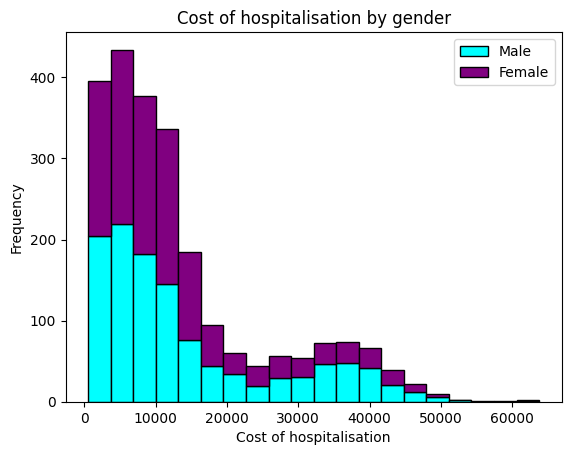

In [58]:
#Visualize the distribution of costs using a histogram, box and whisker plot, and swarm plot.
#State how the distribution is different across gender and tiers of hospitals
#Histogram
male_data = merged_data[merged_data.Gender == 'M']
female_data = merged_data[merged_data.Gender == 'F']
plt.hist([male_data.charges, female_data.charges], bins=20, stacked=True, color=['cyan', 'Purple'], edgecolor='black')

# Adding labels and title
plt.xlabel('Cost of hospitalisation')
plt.ylabel('Frequency')
plt.title('Cost of hospitalisation by gender')
plt.legend(['Male', 'Female'])

# Display the plot
plt.show()

<Axes: xlabel='hospital_tier', ylabel='charges'>

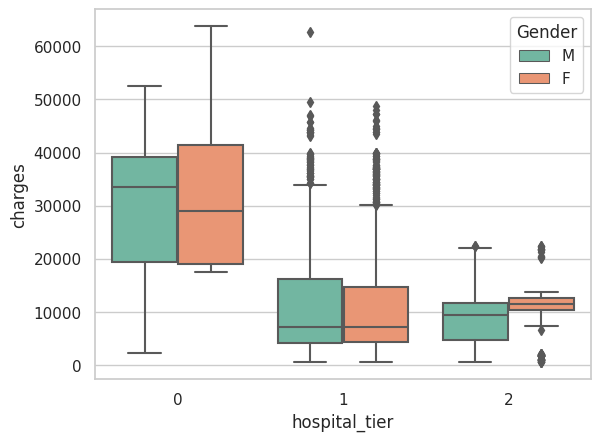

In [59]:
#Gender based hospital charges based on hospital tier
#box and whisker plot
sns.set(style="whitegrid")
sns.boxplot(x=merged_data.hospital_tier, y=merged_data.charges,
    hue=merged_data.Gender,
data=merged_data, palette="Set2", dodge=True)

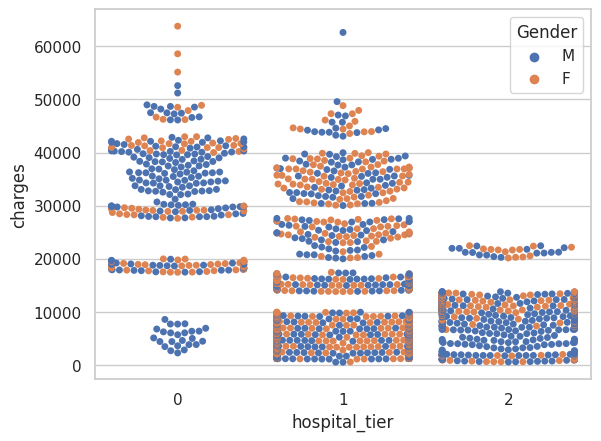

In [60]:
#Swarm plot showing the distribution of hospitalization costs for each hospital tier for each gender
sns.swarmplot(x=merged_data.hospital_tier,
                  y=merged_data.charges,
              hue=merged_data.Gender,
              data=merged_data)
plt.show()

In [61]:
#Radar chart to showcase the median hospitalization cost for each tier of hospitals
r1 = merged_data[merged_data['hospital_tier'] == 0].charges.median()
r2 = merged_data[merged_data['hospital_tier'] == 1].charges.median()
r3 = merged_data[merged_data['hospital_tier'] == 2].charges.median()
radar_df = pd.DataFrame(dict(r=[r1, r2, r3], theta=['Tier 0 hospital', 'Tier 1 hospital', 'Tier 2 hospital']))
fig = px.line_polar(radar_df, r= 'r', theta = 'theta', line_close=True) 
fig.show()

In [62]:
#Frequency table and a stacked bar chart to visualize the count of people in the different tiers of cities and hospitals
#Frequency Table
pd.crosstab(merged_data.city_tier, merged_data.hospital_tier)

hospital_tier,0,1,2
city_tier,,,
0,85,403,241
1,106,479,222
2,109,452,228


In [63]:
#No. of patients in each tier by city
for c in merged_data.city_tier.unique():
    city_data= len(merged_data[merged_data.city_tier == c])

#No. of patients in each tier by hospital
for c in merged_data.hospital_tier.unique():
    hospital_data= len(merged_data[merged_data.hospital_tier == c])

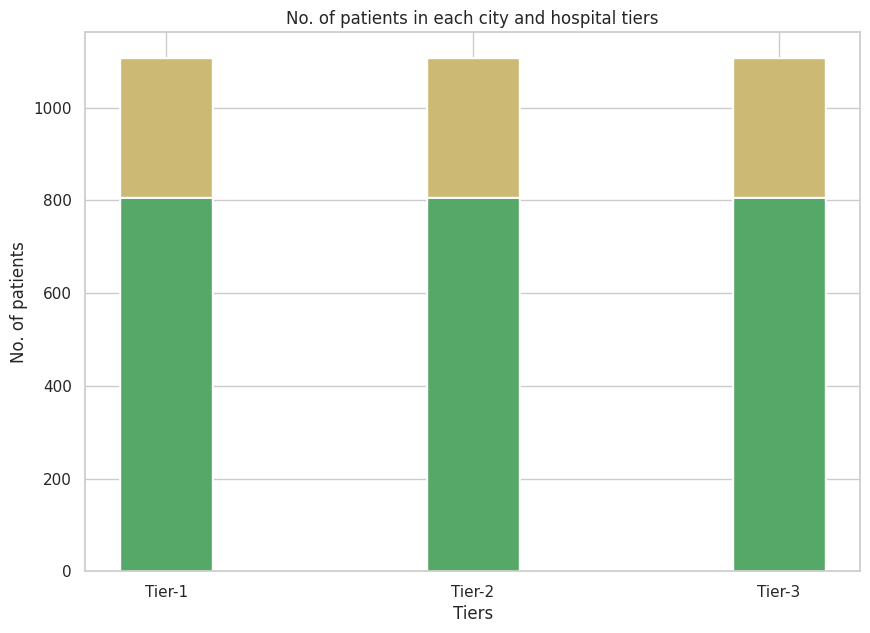

In [64]:
#No. of patients in each tier by city and by hospital
label = merged_data.hospital_tier
fig = plt.figure(figsize = (10, 7))
city_tier = np.array(city_data)
hospital_tier = np.array(hospital_data)
plt.xticks(np.arange(3), ('Tier-1', 'Tier-2', 'Tier-3'))
plt.bar(label, city_tier, color='g', width=0.3)
plt.bar(label, hospital_tier, bottom=city_tier, color='y', width=0.3)
plt.xlabel("Tiers")
plt.ylabel("No. of patients")
plt.title("No. of patients in each city and hospital tiers")
plt.show()

In [65]:
#Null Hypothesis testing
#The average hospitalization costs for the three types of hospitals are not␣ ↪significantly different.
#ANNOVA - pick charges, hospital tier
#H0 - Cost is not different
#HA - Cost is different for each tier
#Check p value for testing the hypothesis
anova_data = [merged_data['charges'], merged_data['hospital_tier']] 
stat, p = f_oneway(*anova_data)
print("stat=%.3f, p=%.3f" % (stat, p)) 
if p > 0.05:
    print('Hospitalization costs are independent on the tier of the hospital') 
else:
    print('Hospitalization costs vary based on the tier of the hospital')

#Since p<0.05, we can REJECT the null hypothesis that the average hospitalization costs for the three types of hospitals are not significantly different.

stat=3019.832, p=0.000
Hospitalization costs vary based on the tier of the hospital


In [66]:
#The average hospitalization costs for the three types of cities are not significantly different.
#ANNOVA - pick charges, city tier
#H0 - Cost is not different
#HA - Cost is different for each tier
#Check p value for testing the hypothesis
anova_data = [merged_data['charges'], merged_data['city_tier']] 
stat, p = f_oneway(*anova_data)
print("stat=%.3f, p=%.3f" % (stat, p)) 
if p > 0.05:
    print('Hospitalization costs are independent on the tier of the city') 
else:
    print('Hospitalization costs vary based on the tier of the city') 
    #Since p<0.05, we can REJECT the null hypothesis that the average hospitalization costs for the three types of cities are not significantly different.

stat=3019.896, p=0.000
Hospitalization costs vary based on the tier of the city


In [67]:
non_smoker_data = merged_data[merged_data['smoker'] == 0].charges.median()
smoker_data = merged_data[merged_data['smoker'] == 1].charges.median()
smoker_data, non_smoker_data
stat, p = kruskal(smoker_data, non_smoker_data)
print("stat=%.3f, p=%.3f" % (stat, p)) 
if p > 0.05:
    print('Hospitalization costs are independent of the smoking status') 
else:
    print('Hospitalization costs vary based on the smoking status')

stat=1.000, p=0.317
Hospitalization costs are independent of the smoking status


In [68]:
#Smoking and heart issues are independent.
#Perform Chi-squared test
#H0 - Smoking and heart issues are independent
#HA - Smoking and heart issues are dependent
chi_sq_data = [[merged_data['smoker'].value_counts(), merged_data['heart_issues'].value_counts()]]
stat, p, dof, expected = chi2_contingency(chi_sq_data) 
alpha = 0.05
print("stat=%.3f, p=%.3f" % (stat, p))
if p > 0.05:
    print('Smoking and heart issues are independent') 
else:
    print('Smoking and heart issues are dependent')
#Since p>0.05, we ACCEPT the null hypothesis that Smoking and heart issues are independent

stat=191.145, p=0.000
Smoking and heart issues are dependent


In [69]:
#Encoding the Gender column
merged_data['Gender'] = label_encoder.fit_transform(merged_data['Gender'])

In [70]:
#Examine the correlation between predictors to identify highly correlated␣ ↪predictors
corr_data = merged_data.copy()
corr_data.drop(['year', 'date', 'month', 'name', 'customer_id'], axis=1, inplace=True) 
corr_data.head()

,children,charges,hospital_tier,city_tier,bmi,hba1c,heart_issues,any_transplants,cancer_history,numberofmajorsurgeries,smoker,state_id_R1011,state_id_R1012,state_id_R1013,Age,Gender
0,0,563.84,1,2,17.58,4.51,0,0,0,1,0,0,0,1,33,1
1,0,570.62,1,0,17.60,4.39,0,0,0,1,0,0,0,1,33,1
2,0,600.00,1,0,16.47,6.35,0,0,1,1,0,0,0,1,32,0
3,0,604.54,2,2,17.70,6.28,0,0,0,1,0,0,0,1,33,1
4,0,637.26,2,2,22.34,5.57,0,0,0,1,0,0,0,1,27,1


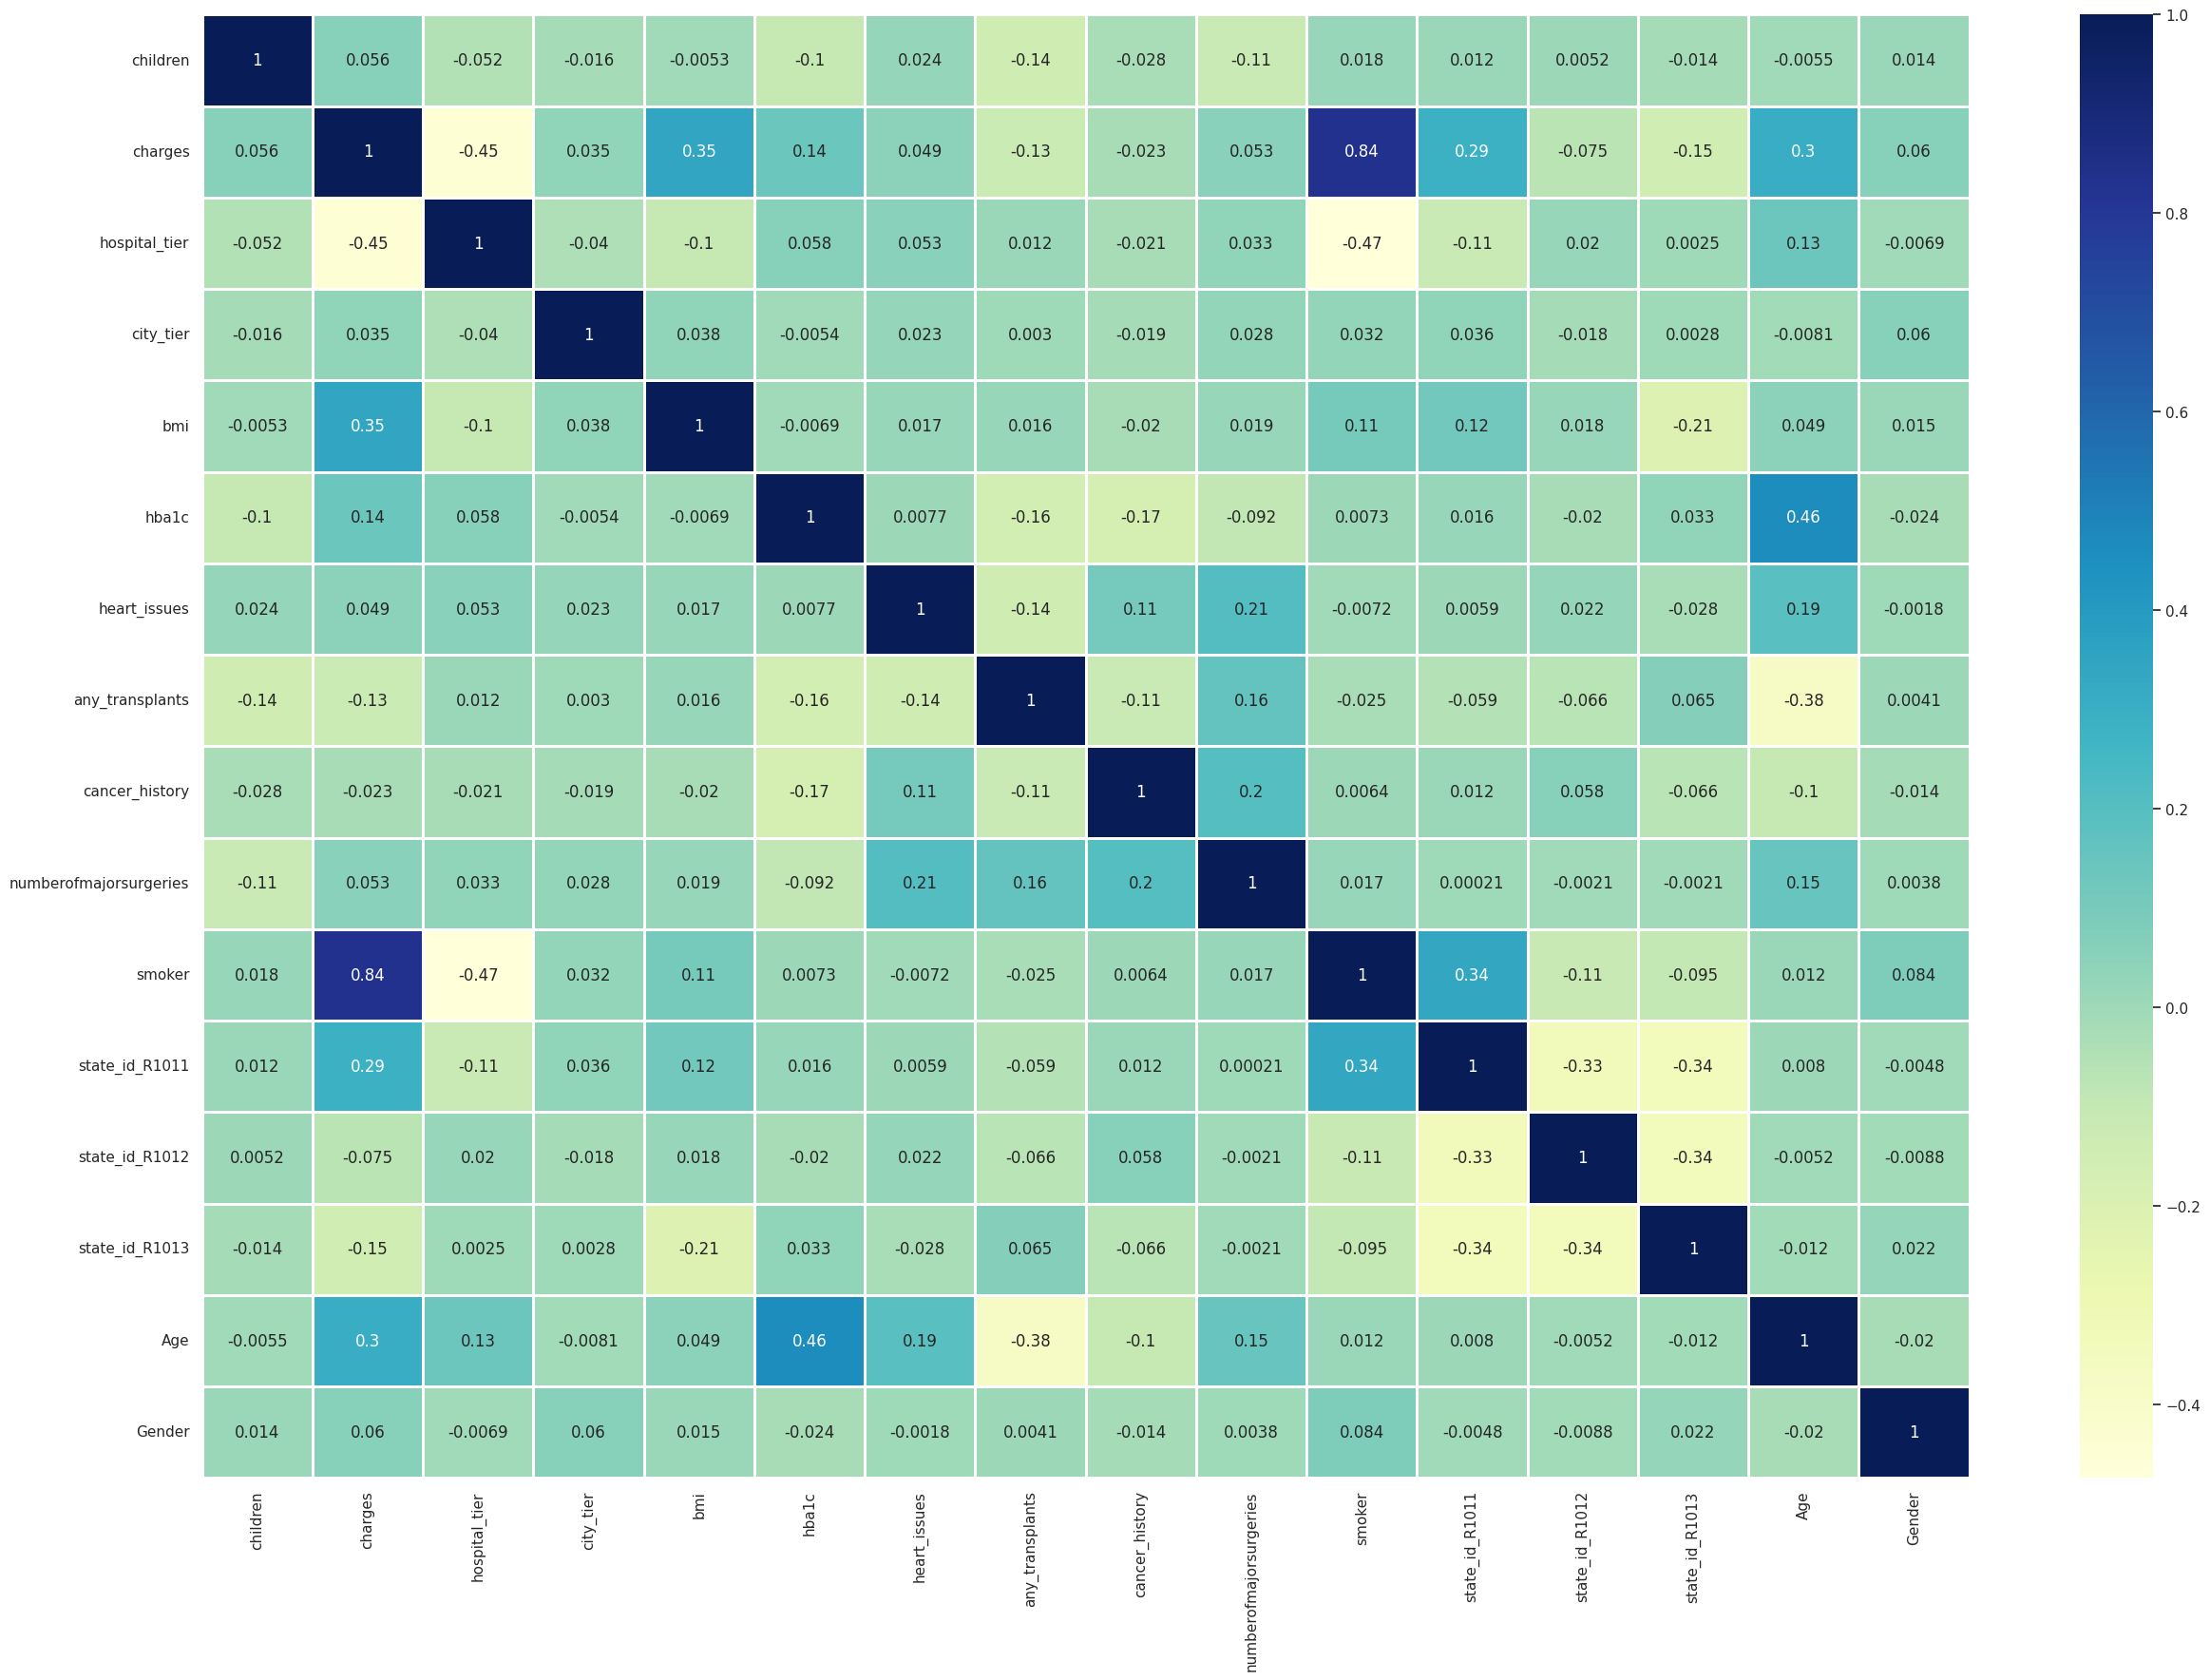

In [71]:
fig = plt.figure(figsize = (30, 20))
sns.heatmap(corr_data.corr(), cmap='YlGnBu', linewidths=2, linecolor='white', annot=True, cbar=True)
plt.show()
#Age and any transplants, hba1c are highly correlated
# Heart issues and number of majoir surgeries are correlated
#Since Gender and smoker data has very correlation with any of the other factors, we can remove them
#corr_data.drop(['Gender_F', 'Gender_M', 'smoker_yes', 'smoker_No'], axis=1, ␣ ↪inplace=True)
#corr_data.drop(['bmi'], axis=1,  inplace=True)

In [72]:
#ML model creation
ml_data = merged_data.copy()
ml_data.drop(['name', 'customer_id', 'year', 'date', 'month'], axis=1, inplace=True)
X = ml_data.drop('charges', axis=1) 
y = ml_data['charges']

#Train test split for model building
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)
X_train.shape, X_test.shape

((1860, 15), (465, 15))

In [73]:
#Incorporate sklearn-pipelines to streamline the workflow
n_splits = 5
pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('regressor', Ridge())])

#parameter for hyperparameter tuning
parameters = {'regressor__alpha':[0.001, 0.01,0.1,1,10,100]} 

#kfold
kfold = KFold(n_splits = n_splits, shuffle=True, random_state=42) 

#Grid search
model_ridge = GridSearchCV(pipeline, parameters, cv=kfold, scoring="neg_mean_absolute_error", verbose=True, refit=True, return_train_score=True)

In [74]:
model_ridge.fit(X_train,y_train) 


Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('regressor', Ridge())]),
             param_grid={'regressor__alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=True)

In [75]:
model_ridge.best_params_

{'regressor__alpha': 0.001}

In [76]:
model_ridge.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', Ridge(alpha=0.001))])

In [77]:
model_ridge.best_score_

-2671.315169355183

In [78]:
model_ridge.feature_names_in_

array(['children', 'hospital_tier', 'city_tier', 'bmi', 'hba1c',
       'heart_issues', 'any_transplants', 'cancer_history',
       'numberofmajorsurgeries', 'smoker', 'state_id_R1011',
       'state_id_R1012', 'state_id_R1013', 'Age', 'Gender'], dtype=object)

In [79]:
grid_search_model = model_ridge.best_estimator_
grid_csv_model =  Ridge(alpha= 0.001)
grid_csv_model.fit(X_train, y_train)
# Print classification report for the Grid Search model
#print("Grid Search - Classification Report:")
#print(classification_report(y_test, y_pred_grid))

Ridge(alpha=0.001)

In [80]:
grid_csv_model.score(X_test, y_test)

0.8375402989364441

In [81]:
y_pred = grid_csv_model.predict(X_test)

In [82]:
ridge_mse = mse(y_test, y_pred)
ridge_r2 = r2_score(y_test, y_pred)
ridge_mae = mae(y_test, y_pred)
print("Ridge Mean squared error: ", ridge_mse)
print("Ridge Mean Absolute error: ", ridge_mae)
print("Ridge R2 score: ", ridge_r2)

Ridge Mean squared error:  23173596.391759563
Ridge Mean Absolute error:  2923.912926436421
Ridge R2 score:  0.8375402989364441


In [83]:
grid_csv_model.n_features_in_

15

In [84]:
feature_importance = grid_csv_model.coef_

In [85]:
grid_csv_model.feature_names_in_

array(['children', 'hospital_tier', 'city_tier', 'bmi', 'hba1c',
       'heart_issues', 'any_transplants', 'cancer_history',
       'numberofmajorsurgeries', 'smoker', 'state_id_R1011',
       'state_id_R1012', 'state_id_R1013', 'Age', 'Gender'], dtype=object)

In [86]:
feature_table = pd.DataFrame(feature_importance, index=X.columns, columns=['Feature_importance'])
feature_table.sort_values(by = 'Feature_importance', ascending=False)

,Feature_importance
smoker,22484.839369
any_transplants,784.279662
cancer_history,613.542162
children,403.997362
bmi,331.020096
Age,264.756937
hba1c,46.582108
city_tier,3.950413
heart_issues,-51.791106
Gender,-113.218908


In [87]:
# Develop Gradient Boost model and determine the variable importance scores and identify the redundant variables
rfg = RandomForestRegressor(n_estimators = 1000, random_state=42)
rfg.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000, random_state=42)

In [88]:
rfg.score(X_test, y_test)

0.8984712977833682

In [89]:
y_pred_rfg = rfg.predict(X_test)

In [90]:
rfg_mae = mae(y_test, y_pred_rfg)
rfg_mae

1966.6491322580625

In [91]:
# Gradient Boosting Regressor
params = {
    "n_estimators": 1000,
    "loss": "squared_error",
    "random_state": 42
}
gbr = GradientBoostingRegressor(**params)

In [92]:
gbr.fit(X_train, y_train)

GradientBoostingRegressor(n_estimators=1000, random_state=42)

In [93]:
gbr.score(X_test, y_test)

0.8755373373121796

In [94]:
y_pred_gbr = gbr.predict(X_test)

In [95]:
gbr_mae = mae(y_test, y_pred_gbr)
gbr_mae

2436.1020734779136

In [96]:
#Case scenario: Testing the accuracy of predictions using new data
#Estimate the cost of hospitalization for Christopher, Ms. Jayna (Date of birth 12/28/1988; height 170 cm; and weight 85 kgs).
#She lives with her partner and two children in a tier-1 city, and her state’s State ID is R1011.
#She was found to be nondiabetic (HbA1c = 5.8). She smokes but is otherwise healthy.
#She has had no transplants or major surgeries. Her father died of lung cancer. #Hospitalization costs will be estimated using tier-1 hospitals.

#Calculate age
dt = str(19881228)
calc_date = pd.to_datetime(dt, format="%Y%m%d") 
calc_date

Timestamp('1988-12-28 00:00:00')

In [97]:
today = datetime.datetime.now()
diff = today - calc_date

In [98]:
age = int(diff.days/365) 
age
#age = 36

36

In [99]:
#Calculate BMI:
height = pow(170/100, 2)
weight = 85
height

bmi = weight/height 
bmi
#bmi - 29.41
#Gender - Female - 0

29.411764705882355

In [100]:
X_train.columns

Index(['children', 'hospital_tier', 'city_tier', 'bmi', 'hba1c',
       'heart_issues', 'any_transplants', 'cancer_history',
       'numberofmajorsurgeries', 'smoker', 'state_id_R1011', 'state_id_R1012',
       'state_id_R1013', 'Age', 'Gender'],
      dtype='object')

In [101]:
X_train.hospital_tier.value_counts()

hospital_tier
1    1048
2     567
0     245
Name: count, dtype: int64

In [102]:
data = [[2,0,0,29.41,5.8,0,0,1,0,1,1,0,0,36,0]]
new_data = pd.DataFrame(data, columns=['children', 'hospital_tier','city_tier', 'bmi', 'hba1c',
'heart_issues', 'any_transplants', 'cancer_history', 'numberofmajorsurgeries', 'smoker', 'state_id_R1011', 'state_id_R1012', 'state_id_R1013', 'Age', 'Gender'])
new_data

,children,hospital_tier,city_tier,bmi,hba1c,heart_issues,any_transplants,cancer_history,numberofmajorsurgeries,smoker,state_id_R1011,state_id_R1012,state_id_R1013,Age,Gender
0,2,0,0,29.41,5.8,0,0,1,0,1,1,0,0,36,0


In [103]:
#Find the predicted hospitalization cost using the best models
hospital_cost = []
#Predicted cost using Ridge Regression model
cost = grid_csv_model.predict(new_data)
hospital_cost.append(cost)

#Predicted cost using Random Forest Regression model
cost_rfg = rfg.predict(new_data)
hospital_cost.append(cost_rfg)

#Predicted cost using Gradient Boost Regression model
cost_gbr = gbr.predict(new_data)
hospital_cost.append(cost_gbr)

hospital_cost

[array([31873.72650225]), array([26447.09205]), array([29050.22759146])]

In [104]:
#Average predicted cost
Avg_cost = np.mean(hospital_cost)
print("The average hospitalization cost for the given case scenario using the best models: ", np.round(Avg_cost, 2))

The average hospitalization cost for the given case scenario using the best models:  29123.68
